In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from tqdm import tqdm
from scipy.signal import butter, filtfilt, welch, spectrogram
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

# Data preprocessing, filtering, and segmentation
- We capture our EEG data as a pandas pickle object, from which we extract numpy arrays for both time stamps and eeg data.

In [3]:
# original_eeg_df = pd.read_csv("./241217_seizure_KCNA_long1.dat")
# original_eeg_df
# eeg_df = original_eeg_df[["EEG", "Max_Time"]]
# filename = 'cached_EEG_1217.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(eeg_df, file)

# print(f"EEG DF saved to {filename}")

In [4]:
stored_data = "cached_EEG_1217.pkl"
with open(stored_data, 'rb') as f:
    eeg_df = pickle.load(f)

In [5]:
eeg_df.head(5)

,EEG,Max_Time
0,0.0,0.000
1,6023.8,1.953
2,5993.6,3.906
3,5963.9,5.859
4,5938.9,7.812


In [6]:
eeg_signal = eeg_df['EEG'].to_numpy()
time_stamps = eeg_df['Max_Time'].to_numpy()

- We preprocess the data to remove all other interferances (such as muscle twitches), by running a high pass filter to exclude all frequencies below 1Hz

In [7]:
SAMPLING_FS = 512
def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

filtered_signal = highpass_filter(eeg_signal, 5, SAMPLING_FS)

In [8]:
filtered_signal.shape

(44237001,)

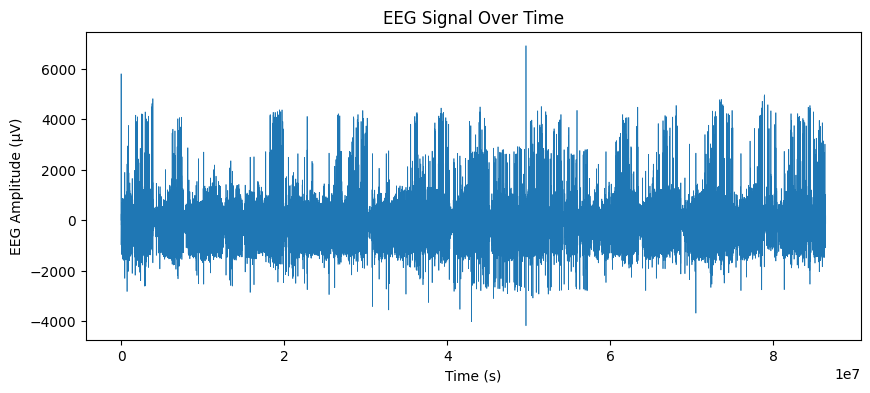

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(time_stamps, filtered_signal, linewidth=0.5)  # Convert ms to seconds for readability
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal Over Time")
plt.show()

- We then apply TKEO to suppress noise and amplify sudden changes in EEG data.

In [10]:
def tkeo(signal):
    squared_signal = signal[1:-1]*signal[1:-1]
    prev_and_next = signal[2:]*signal[:-2]
    return squared_signal - prev_and_next

tkeo_filtered_signal = tkeo(filtered_signal)

In [11]:
tkeo_filtered_signal.shape

(44236999,)

- To make our data easier to process and analyze at smaller time-intervals (to narrow down the precise point in time that a seizure occurs), we segment the data into 5 second intervals, with an overlap of around half a second.

In [12]:
SEGMENTATION_LENGTH = 2560
NUM_SAMPLES = len(filtered_signal)
TRIMMED_LENGTH = NUM_SAMPLES % SEGMENTATION_LENGTH
NUMBER_OF_SEGMENTATIONS = NUM_SAMPLES // SEGMENTATION_LENGTH
trimmed_signal = filtered_signal[TRIMMED_LENGTH:]
trimmed_time_stamps = time_stamps[TRIMMED_LENGTH:]
np.shape(trimmed_signal)

(44236800,)

In [13]:
SEGMENTATION_LENGTH = 2560  # Length of each segment
OVERLAP = 0.5 # Overlap fraction (e.g., 50% overlap)
STEP_SIZE = int(SEGMENTATION_LENGTH * (1 - OVERLAP))  # Step size for sliding window


total_samples = len(trimmed_signal)
NUMBER_OF_SEGMENTATIONS = (total_samples - SEGMENTATION_LENGTH) // STEP_SIZE + 1

# Create segmented arrays with overlap
segmented_signal = np.array([
    trimmed_signal[i : i + SEGMENTATION_LENGTH] 
    for i in range(0, total_samples - SEGMENTATION_LENGTH + 1, STEP_SIZE)
])

segmented_time_stamps = np.array([
    trimmed_time_stamps[i : i + SEGMENTATION_LENGTH] 
    for i in range(0, total_samples - SEGMENTATION_LENGTH + 1, STEP_SIZE)
])

print(segmented_signal.shape)  # (num_segments, SEGMENTATION_LENGTH)
print(segmented_time_stamps.shape)  # (num_segments, SEGMENTATION_LENGTH)


(34559, 2560)
(34559, 2560)


Text(0.5, 1.0, 'EEG Signal Over Time')

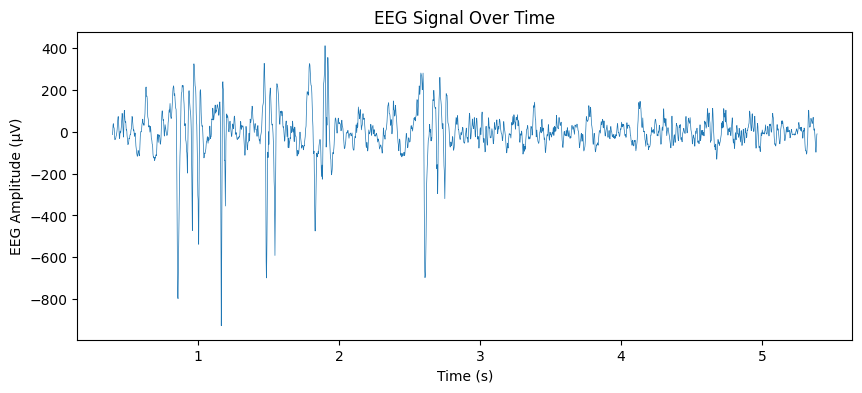

In [14]:
# We plot an example of a segmented piece of data
plt.figure(figsize=(10, 4))
plt.plot(segmented_time_stamps[0] / 1000, segmented_signal[0], linewidth=0.5)  # Convert ms to seconds for readability
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal Over Time")
##plt.show()

# Features Extraction for Learning Algorithm
- We employ signal processing techniques to extract several key features of our signal to be processed by some learning algorithm to categorize seizure events.
- There are three main types of features we may capture:
    - Time-domain features (e.g., amplitude, variance, energy)
    - Frequency-domain features (e.g., power spectral density on frequency bands using Fourier Transform)
    - Time-frequency features (e.g., wavelet transform for analyzing transient events)

In [15]:
SAMPLE_INDEX = 1000
TEST_SEGMENT = segmented_signal[SAMPLE_INDEX]
TEST_TIME_STAMPS = segmented_time_stamps[SAMPLE_INDEX]

## Time-domain features
- We have the following features to calculate per segmentation:  
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Mean</td>
        <td>Average amplitude of EEG segment</td>
    </tr>
    <tr>
        <td>Variance</td>
        <td>Measures EEG signal dispersion</td>
    </tr>
    <tr>
        <td>Standard Deviation</td>
        <td>Spread of EEG values</td>
    </tr>
    <tr>
        <td>Kurtosis</td>
        <td>Measures peak sharpness of EEG segment</td>
    </tr>
    <tr>
        <td>Skewness</td>
        <td>Asymmetry of signal distribution</td>
    </tr>
    <tr>
        <td>Energy</td>
        <td>Sum of squared amplitudes</td>
    </tr>
    <tr>
        <td>Root Mean Square</td>
        <td>Measures overall amplitude strength</td>
    </tr>
    <tr>
        <td>Entropy</td>
        <td>Measures randomness</td>
    </tr>
    <tr>
        <td>Zero-crossing Rate</td>
        <td>Measures oscillation of amplitude</td>
    </tr>
</table>


In [16]:
TEST_SEGMENT

array([-174.08638369, -191.89979664, -198.14989593, ...,  -24.13973036,
          7.24687015,   -6.16170276], shape=(2560,))

In [17]:
def compute_time_domain_features(signal_fragment):
    features = {}
    
    # Basic Statistical Features
    features["Mean"] = np.mean(signal_fragment)
    features["Variance"] = np.var(signal_fragment)
    # features["Standard_Deviation"] = np.std(signal_fragment)
    # features["Kurtosis"] = stats.kurtosis(signal_fragment)
    # features["Skewness"] = stats.skew(signal_fragment)
    
    # Energy & Power Features
    features["Energy"] = np.sum(np.square(signal_fragment))
    # features["RMS"] = np.sqrt(np.mean(np.square(signal_fragment)))
    
    # # Entropy (Shannon Entropy)
    # probability_distribution = np.histogram(signal_fragment, bins=10, density=True)[0]
    # probability_distribution = probability_distribution[probability_distribution > 0]  # Avoid log(0)
    # features["Entropy"] = -np.sum(probability_distribution * np.log2(probability_distribution))

    # # ZCR (Zero Crossing Rate)
    # zero_crossings = np.where(np.diff(np.sign(signal_fragment)))[0]
    # features["Zero_Crossing_Rate"] = len(zero_crossings) / len(signal_fragment)
    
    return features

time_features = compute_time_domain_features(TEST_SEGMENT)
print("Extracted Time-Domain Features:")
for key, value in time_features.items():
    print(f"{key}: {value:.4f}")

Extracted Time-Domain Features:
Mean: -0.4689
Variance: 97681.0473
Energy: 250064044.0376


## Frequency-Domain Features
- We have the following frequency-domain features to capture for each segmentation
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Peak Frequency</td>
        <td>Frequency with the highest power</td>
    </tr>
    <tr>
        <td>Spectral Entropy</td>
        <td>Measures disorder in the power spectrum</td>
    </tr>
    <tr>
        <td>Mean Frequency</td>
        <td>Weighted average of frequency components</td>
    </tr>
    <tr>
        <td>Power in Frequency Bands</td>
        <td>Power in Delta, Theta, Alpha, Beta, and Gamma bands</td>
    </tr>
</table>

- This is the Welch PSD of our test eeg segment


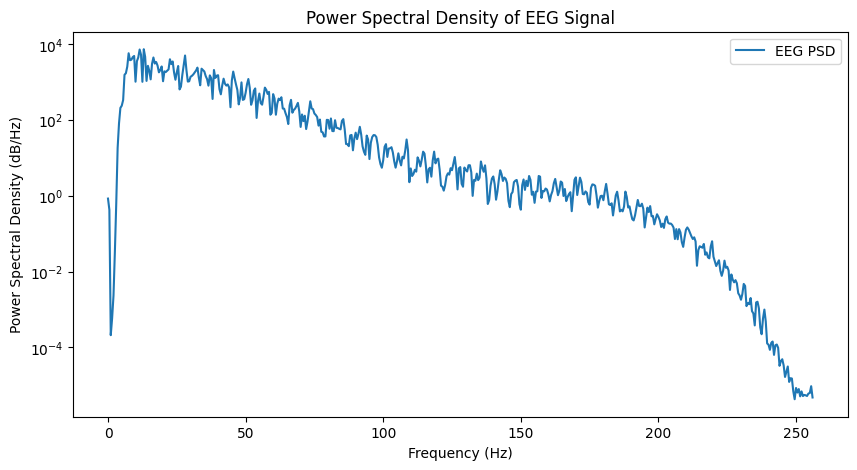

In [18]:
def compute_psd(data, fs):
    f, psd = welch(data, fs, nperseg=fs*2)
    return f, psd

f, psd_raw = compute_psd(TEST_SEGMENT, SAMPLING_FS)
plt.figure(figsize=(10,5))
plt.semilogy(f, psd_raw, label="EEG PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB/Hz)")
plt.title("Power Spectral Density of EEG Signal")
plt.legend()
plt.show()

- We now compute some of our frequency domain features:

In [19]:
def compute_frequency_features(eeg_signal, fs):
    features = {}

    # Compute Power Spectral Density (PSD) using Welch’s method
    f, psd = welch(eeg_signal, fs, nperseg=fs*2)

    # Peak Frequency (Highest Power)
    peak_freq = f[np.argmax(psd)]
    # features["Peak_Frequency"] = peak_freq

    # Mean Frequency (Weighted Average)
    mean_freq = np.sum(f * psd) / np.sum(psd)
    features["Mean_Frequency"] = mean_freq

    # Spectral Entropy (Normalized Shannon Entropy of PSD)
    psd_norm = psd / np.sum(psd)  # Normalize PSD
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))  # Avoid log(0)
    features["Spectral_Entropy"] = spectral_entropy

    return features

frequency_features = compute_frequency_features(TEST_SEGMENT, SAMPLING_FS)

# Print extracted features
print("Extracted Frequency-Domain Features:")
for key, value in frequency_features.items():
    print(f"{key}: {value:.4f}")

Extracted Frequency-Domain Features:
Mean_Frequency: 25.7869
Spectral_Entropy: 6.6030


### EEG Frequency Band Decomposition
- From what I have gathered, the following frequency bands correlate to different brain waves in rodents:
    - Delta (0.5–4 Hz) → Deep sleep, unconscious states
    - Theta (4–8 Hz) → Drowsiness, early seizure activity
    - Alpha (8–13 Hz) → Relaxed wakefulness
    - Beta (13–30 Hz) → Active thinking, alertness
    - Gamma (30–100 Hz) → High-frequency oscillations, seizure biomarkers.
- We can perform a bandpass filter on each frequency band and then analyze the power of each band using Welch's method.

In [20]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [21]:
delta_band = bandpass_filter(TEST_SEGMENT, 0.5, 4, 512)
theta_band = bandpass_filter(TEST_SEGMENT, 4, 8, 512)
alpha_band = bandpass_filter(TEST_SEGMENT, 8, 13, 512)
beta_band = bandpass_filter(TEST_SEGMENT, 13, 30, 512)
gamma_band = bandpass_filter(TEST_SEGMENT, 30, 100, 512)

frequency_bands = [delta_band, theta_band, alpha_band, beta_band, gamma_band]

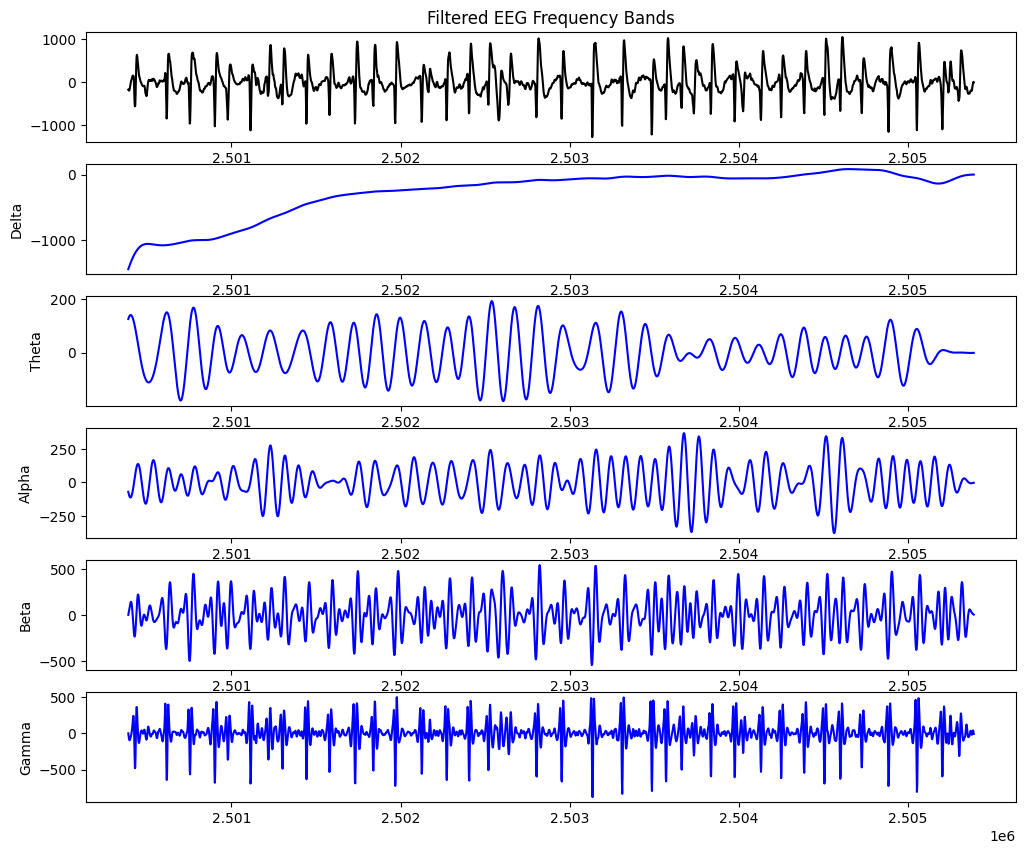

In [22]:
FREQUENCY_BAND_MAPPING = {
    0 : "Delta",
    1 : "Theta",
    2 : "Alpha",
    3 : "Beta",
    4 : "Gamma"
}


plt.figure(figsize=(12,10))
plt.subplot(6, 1, 1)
plt.plot(TEST_TIME_STAMPS, TEST_SEGMENT, label="Raw EEG", color='black')
plt.xlabel("Time (s)")
plt.title("Filtered EEG Frequency Bands")
for i in range(2, 7):
    plt.subplot(6, 1, i)
    plt.plot(TEST_TIME_STAMPS, frequency_bands[i-2], color='blue')
    plt.ylabel(FREQUENCY_BAND_MAPPING[i-2])


plt.show()

- Now we could compute the power of each frequency band and use that as a feature for whatever learning model that we create.

- Finally, computing the power of each frequency band:
    - We do this by taking the integral of the PSD over each specified frequency interval
- Higher frequency energy bands.

In [23]:
def compute_band_power(psd, f, low, high):
    idx_band = np.logical_and(f >= low, f <= high)
    return np.trapz(psd[idx_band], f[idx_band])

delta_power = compute_band_power(psd_raw, f, 0.5, 4)
theta_power = compute_band_power(psd_raw, f, 4, 8)
alpha_power = compute_band_power(psd_raw, f, 8, 13)
beta_power = compute_band_power(psd_raw, f, 13, 30)
gamma_power = compute_band_power(psd_raw, f, 30, 100)

band_powers = {
    "Delta (0.5-4 Hz)": delta_power,
    "Theta (4-8 Hz)": theta_power,
    "Alpha (8-13 Hz)": alpha_power,
    "Beta (13-30 Hz)": beta_power,
    "Gamma (30-100 Hz)": gamma_power,
}

print("EEG Band Power:")
for band, power in band_powers.items():
    print(f"{band}: {power:.4f}")

EEG Band Power:
Delta (0.5-4 Hz): 29.9844
Theta (4-8 Hz): 7168.1235
Alpha (8-13 Hz): 20797.9461
Beta (13-30 Hz): 40523.0335
Gamma (30-100 Hz): 32430.4986


/var/folders/qq/k25z65411f76vz0kh3p7b2000000gn/T/ipykernel_10327/3507049422.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx_band], f[idx_band])


## Time-Frequency Features
- I don't really understand how some of this more advanced signal processing works, but I've narrowed down my search for features into three key Time-Frequency Features
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Short-Time Fourier Transform</td>
        <td>Tracks frequency variations over time</td>
    </tr>
    <tr>
        <td>Wavelet Transform</td>
        <td>Captures time-localized frequency patterns</td>
    </tr>
    <tr>
        <td>Hilbert Transform</td>
        <td>Spread of EEG values</td>
    </tr>
</table>

- I will be excluding hilbert transform for now, as I do not fully understand what it really does for the signal.

## Short-Time Fourier Transform

- The following is some code I've copied from my EECS16A lab on how to perform stft on a short clip of data. Nothing too exciting happend in the data we extracted.

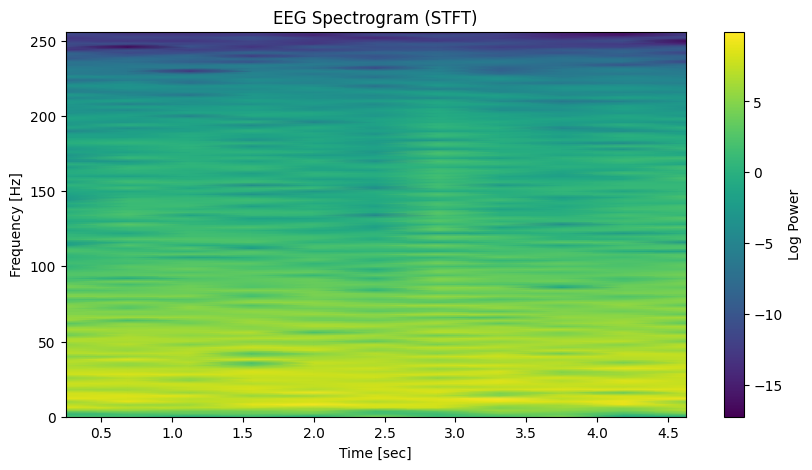

In [24]:
def compute_stft(eeg_signal, fs):
    f, t, Sxx = spectrogram(eeg_signal, fs, nperseg=fs//2)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, np.log(Sxx + 1e-10), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title("EEG Spectrogram (STFT)")
    plt.colorbar(label="Log Power")
    plt.show()
    
    return f, t, Sxx

f, t, Sxx = compute_stft(TEST_SEGMENT, SAMPLING_FS)

- For STFT, we may extract the following data:
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Spectral Centroid</td>
        <td>Weighted mean of frequencies</td>
    </tr>
    <tr>
        <td>Spectral Bandwidth</td>
        <td>Spread of frequencies around the centroid</td>
    </tr>
    <tr>
        <td>Spectral Entropy</td>
        <td>Disorder in the spectrogram</td>
    </tr>
    <tr>
        <td>Spectral Flatness</td>
        <td>Tonality/Noisyness of the signal</td>
    </tr>
    <tr>
        <td>Spectrogram Energy</td>
        <td>Total energy in time-frequency domain</td>
    </tr>
</table>

In [25]:
import numpy as np
import scipy.signal as signal
import scipy.stats as stats

def extract_stft_features(eeg_signal, fs):
    f, t, Sxx = signal.spectrogram(eeg_signal, fs, nperseg=fs//2)

    # Normalize spectrogram to avoid numerical issues
    Sxx = np.abs(Sxx) + 1e-10  # Avoid log(0) issues

    features = {}

    # Spectral Centroid (Weighted mean of frequencies)
    spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
    features["Spectral_Centroid_Mean"] = np.mean(spectral_centroid)
    features["Spectral_Centroid_Std"] = np.std(spectral_centroid)

    # Spectral Bandwidth (Variance around centroid)
    spectral_bandwidth = np.sqrt(np.sum(((f[:, None] - spectral_centroid[None, :])**2) * Sxx, axis=0) / np.sum(Sxx, axis=0))
    features["Spectral_Bandwidth_Mean"] = np.mean(spectral_bandwidth)
    features["Spectral_Bandwidth_Std"] = np.std(spectral_bandwidth)

    # Spectral Entropy (Shannon entropy over time)
    Sxx_norm = Sxx / np.sum(Sxx, axis=0)  # Normalize
    spectral_entropy = -np.sum(Sxx_norm * np.log2(Sxx_norm + 1e-10), axis=0)
    features["Spectral_Entropy_Mean"] = np.mean(spectral_entropy)
    features["Spectral_Entropy_Std"] = np.std(spectral_entropy)

    # Spectral Flatness (Ratio of geometric mean to arithmetic mean)
    spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
    features["Spectral_Flatness_Mean"] = np.mean(spectral_flatness)
    features["Spectral_Flatness_Std"] = np.std(spectral_flatness)

    # Total Energy in Spectrogram
    features["Spectrogram_Total_Energy"] = np.sum(Sxx)

    return features

stft_features = extract_stft_features(TEST_SEGMENT, SAMPLING_FS)

print("Extracted STFT-Based Features:")
for key, value in stft_features.items():
    print(f"{key}: {value:.4f}")


Extracted STFT-Based Features:
Spectral_Centroid_Mean: 25.9734
Spectral_Centroid_Std: 2.0039
Spectral_Bandwidth_Mean: 17.2620
Spectral_Bandwidth_Std: 1.3177
Spectral_Entropy_Mean: 4.3123
Spectral_Entropy_Std: 0.1995
Spectral_Flatness_Mean: 0.0052
Spectral_Flatness_Std: 0.0017
Spectrogram_Total_Energy: 544052.6208


## DWT Decomposition
- I have found two Wavelet decomposition methods, a continuous wavelet transform that uses morlet wavlets, and a discrete wavelet transform that uses daubauchies wavelets.
    - A research into the two options reveals that the CWT is more accurate, but a lot more computationally intensive than a DWT approach, which I believe should be sufficient for our analysis.
- This is the CWT approach:

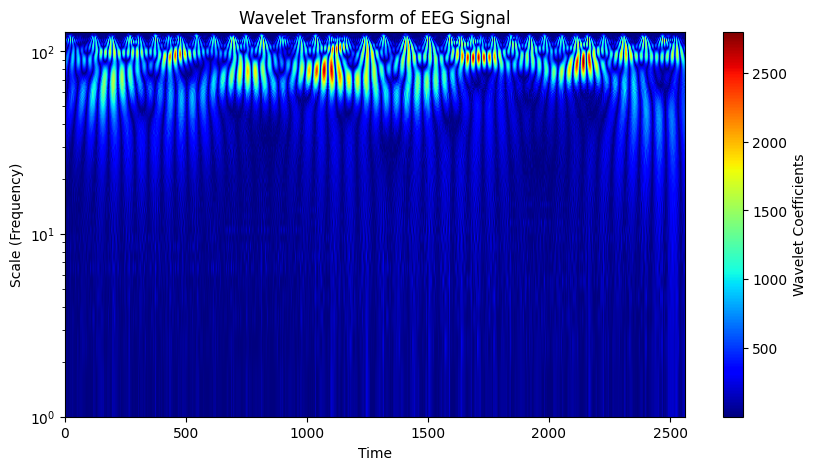

In [26]:
import pywt

def compute_CWT_transform(eeg_signal, wavelet='morl'):
    scales = np.arange(1, 128)  # Define scales for wavelet transform
    coefs, frequencies = pywt.cwt(eeg_signal, scales, wavelet)

    plt.figure(figsize=(10, 5))
    plt.imshow(np.abs(coefs), aspect='auto', cmap='jet', extent=[0, len(eeg_signal), 1, 128])
    plt.yscale("log")
    plt.colorbar(label="Wavelet Coefficients")
    plt.xlabel("Time")
    plt.ylabel("Scale (Frequency)")
    plt.title("Wavelet Transform of EEG Signal")
    plt.show()
    
    return coefs, frequencies

# Example usage:
coefs, frequencies = compute_CWT_transform(TEST_SEGMENT)


- This is the DWT approach

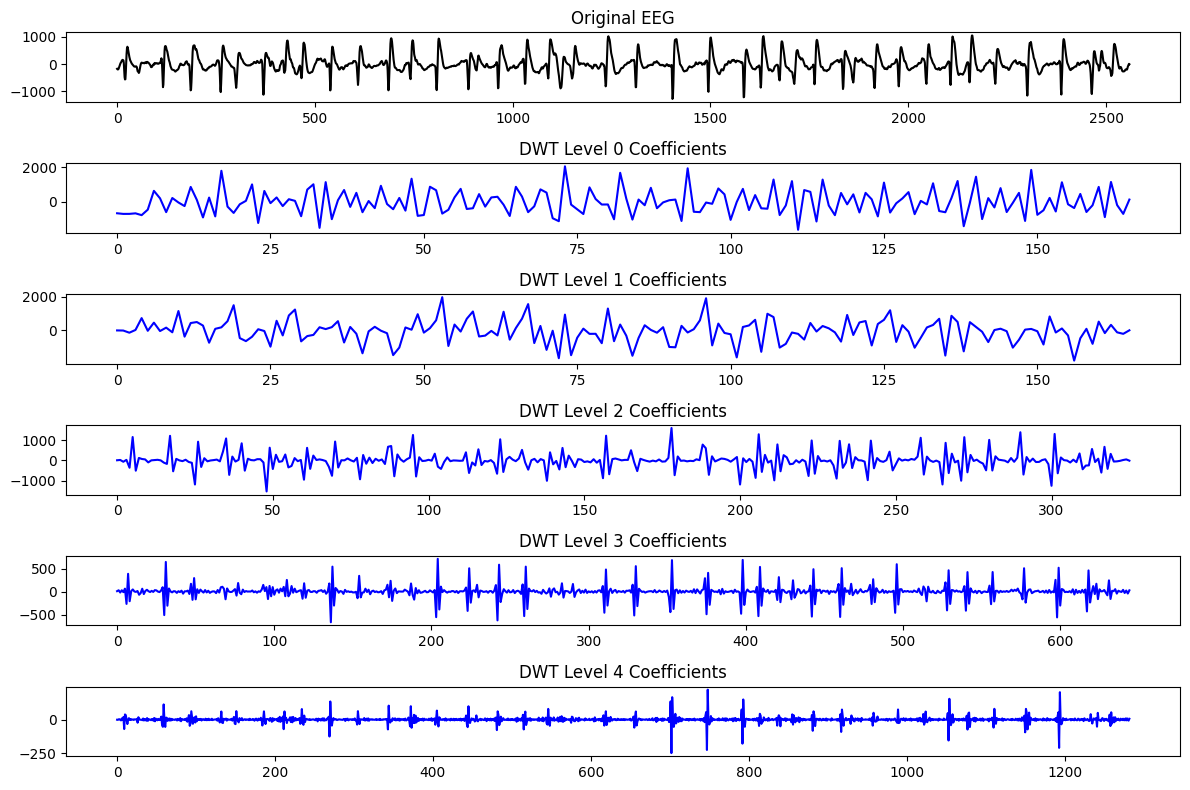

In [27]:
def compute_dwt(eeg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)

    # Plot Approximation and Detail Coefficients
    plt.figure(figsize=(12, 8))
    plt.subplot(len(coeffs)+1, 1, 1)
    plt.plot(eeg_signal, color='black')
    plt.title("Original EEG")
    for i, coef in enumerate(coeffs):
        plt.subplot(len(coeffs)+1, 1, i+2)
        plt.plot(coef, color='blue')
        plt.title(f"DWT Level {i} Coefficients")
    plt.tight_layout()
    plt.show()

    return coeffs

# Example usage:
dwt_coeffs = compute_dwt(TEST_SEGMENT)

- Now we may try to extract features from the DWT approach. We will be focusing on basic statistical features, energy, as well as entropy.
    - I believe that high wavelet energy (particularly in DWT level 4 and level 3, which are D1 and D2 coefficients respectively), may correlate to seizure activity.
    - I also believe that increased Wavelet Entropy may indicate the EEG data getting more "choatic" during seizures.

In [28]:
def extract_wavelet_features(eeg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)
    
    features = {}
    
    for i, coef in enumerate(coeffs):
        # Statistical features
        features[f"Wavelet_Mean_L{i}"] = np.mean(coef)
        features[f"Wavelet_Variance_L{i}"] = np.var(coef)
        features[f"Wavelet_Skewness_L{i}"] = stats.skew(coef)
        features[f"Wavelet_Kurtosis_L{i}"] = stats.kurtosis(coef)
        
        # Energy of wavelet coefficients
        features[f"Wavelet_Energy_L{i}"] = np.sum(np.square(coef))
        
        # Entropy of wavelet coefficients
        coef_prob = np.abs(coef) / np.sum(np.abs(coef))  # Normalize
        features[f"Wavelet_Entropy_L{i}"] = -np.sum(coef_prob * np.log2(coef_prob + 1e-10))  # Shannon Entropy
    
    return features

# Example usage:
wavelet_features = extract_wavelet_features(TEST_SEGMENT)
print("Extracted Wavelet-Based Features:")
for key, value in wavelet_features.items():
    print(f"{key}: {value:.4f}")

Extracted Wavelet-Based Features:
Wavelet_Mean_L0: -23.2049
Wavelet_Variance_L0: 547378.6566
Wavelet_Skewness_L0: 0.4459
Wavelet_Kurtosis_L0: -0.1739
Wavelet_Energy_L0: 90954242.7878
Wavelet_Entropy_L0: 7.0037
Wavelet_Mean_L1: -35.9266
Wavelet_Variance_L1: 477974.2815
Wavelet_Skewness_L1: -0.0134
Wavelet_Kurtosis_L1: 0.3629
Wavelet_Energy_L1: 79557989.8722
Wavelet_Entropy_L1: 6.8370
Wavelet_Mean_L2: -6.8114
Wavelet_Variance_L2: 200571.5796
Wavelet_Skewness_L2: 0.3455
Wavelet_Kurtosis_L2: 2.1488
Wavelet_Energy_L2: 65401459.9488
Wavelet_Entropy_L2: 7.3858
Wavelet_Mean_L3: -0.1904
Wavelet_Variance_L3: 24766.6931
Wavelet_Skewness_L3: 0.2087
Wavelet_Kurtosis_L3: 6.4073
Wavelet_Energy_L3: 15974540.4330
Wavelet_Entropy_L3: 8.0344
Wavelet_Mean_L4: -0.0015
Wavelet_Variance_L4: 680.1267
Wavelet_Skewness_L4: -0.3553
Wavelet_Kurtosis_L4: 28.9048
Wavelet_Energy_L4: 872602.6117
Wavelet_Entropy_L4: 9.0929


# Aggregating Feature and Data for Model Training
- We now calculate all features for each data segment and classify each segment as a seizure/non-seizure to construct a dataset for training.

In [29]:
annotations_1217 = pd.read_excel("./zqm_annotation_seizure.xlsx", sheet_name="KCNA_1217")
annotations_1207 = pd.read_excel("./zqm_annotation_seizure.xlsx", sheet_name="KCNA_1207")

Drop all NaN entries

In [30]:
annotations_1217 = annotations_1217[['Start', 'End']].map(lambda x: 60*1000*x)
annotations_1217 = annotations_1217.dropna()


Zip all features and labels into a datset

In [31]:
def check_seizure_overlap(segment_start, segment_end, annotations):
    for _, row in annotations.iterrows():
        seizure_start = row["Start"]
        seizure_end = row["End"]
        if (seizure_start <= segment_start <= seizure_end) or (seizure_start <= segment_end <= seizure_end):
            return 1

    return 0

def create_dataset(input_segments, input_segment_time_stamps, annotations):
    feature_rows = []
    for index in tqdm(range(len(input_segments)), desc="Extracting Features", unit="segment"):
        segment = input_segments[index]
        segment_start = input_segment_time_stamps[index][0]
        segment_end = input_segment_time_stamps[index][-1]

        # Extract features
        time_features = compute_time_domain_features(segment)
        frequency_features = compute_frequency_features(segment, SAMPLING_FS)
        f, psd_raw = compute_psd(segment, SAMPLING_FS)
        band_powers = {
            # "Delta_BandPower": compute_band_power(psd_raw, f, 0.5, 4),
            "Theta_BandPower": compute_band_power(psd_raw, f, 4, 8),
            "Alpha_BandPower": compute_band_power(psd_raw, f, 8, 13),
            "Beta_BandPower": compute_band_power(psd_raw, f, 13, 30),
            "Gamma_BandPower": compute_band_power(psd_raw, f, 30, 100),
        }
        stft_features = extract_stft_features(segment, SAMPLING_FS)
        wavelet_features = extract_wavelet_features(segment)

        is_seizure = check_seizure_overlap(segment_start, segment_end, annotations)

        # Merge all feature dictionaries into a single row
        row_features = {
            "Segment_Start": segment_start,
            "Segment_End": segment_end,
            **time_features,
            # **frequency_features,
            # **band_powers,
            # **stft_features,
            **wavelet_features,
            "Label": is_seizure  # This is what we use to train our SVM
        }

        feature_rows.append(row_features)

    # Convert list of dictionaries into a DataFrame
    features_df = pd.DataFrame(feature_rows)
    return features_df

features_df = create_dataset(segmented_signal, segmented_time_stamps, annotations_1217)

Extracting Features:   0%|          | 0/34559 [00:00<?, ?segment/s]/var/folders/qq/k25z65411f76vz0kh3p7b2000000gn/T/ipykernel_10327/3507049422.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx_band], f[idx_band])
Extracting Features:  30%|███       | 10497/34559 [00:49<01:52, 213.13segment/s]


KeyboardInterrupt: 

In [ ]:
features_df

,Segment_Start,Segment_End,Mean,Variance,Energy,Wavelet_Mean_L0,Wavelet_Variance_L0,Wavelet_Skewness_L0,Wavelet_Kurtosis_L0,Wavelet_Energy_L0,...,Wavelet_Kurtosis_L3,Wavelet_Energy_L3,Wavelet_Entropy_L3,Wavelet_Mean_L4,Wavelet_Variance_L4,Wavelet_Skewness_L4,Wavelet_Kurtosis_L4,Wavelet_Energy_L4,Wavelet_Entropy_L4,Label
0,3.925780e+02,5.390625e+03,0.133302,11294.153083,2.891308e+07,2.168879,66760.498505,0.505878,4.775417,1.108302e+07,...,34.509502,1.175700e+06,8.645836,0.000941,150.215725,0.670805,23.870574,192726.775724,9.600762,1
1,2.892578e+03,7.890625e+03,0.005585,2046.493309,5.239023e+06,-2.316995,16968.533984,-0.183338,1.689567,2.817668e+06,...,1.601494,4.415115e+05,8.914031,0.001504,62.849341,0.273253,7.997844,80635.707358,9.861762,1
2,5.392578e+03,1.039062e+04,0.046365,2509.467843,6.424243e+06,1.471668,21714.337413,-0.416981,0.995428,3.604940e+06,...,1.088424,5.073485e+05,8.911733,0.005927,71.381636,0.169025,6.211021,91582.683932,9.853243,0
3,7.892578e+03,1.289062e+04,0.112010,2872.284451,7.353080e+06,4.155762,23906.430743,-0.246074,-0.320155,3.971334e+06,...,0.227402,6.587243e+05,8.906171,0.005014,75.957332,-0.045614,0.391610,97453.289562,9.872450,0
4,1.039258e+04,1.539062e+04,0.019593,3092.798367,7.917565e+06,-4.052592,24377.012016,0.015018,-0.362202,4.049310e+06,...,0.443055,6.683944e+05,8.886716,0.004102,80.065544,-0.020097,0.214306,102724.114206,9.899466,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34554,8.638528e+07,8.639028e+07,0.034506,3431.833391,8.785497e+06,1.391228,28886.798688,-0.030495,1.289154,4.795530e+06,...,-0.195625,4.562381e+05,8.929663,0.009361,57.571426,0.004151,0.499220,73864.251810,9.870725,0
34555,8.638778e+07,8.639278e+07,0.037959,2347.119478,6.008630e+06,-5.435802,18973.090992,-0.080132,0.990218,3.154438e+06,...,0.516177,4.431001e+05,8.884489,0.004449,61.868460,-0.055149,0.454504,79377.259814,9.876396,0
34556,8.639028e+07,8.639528e+07,-0.196741,2515.136504,6.438849e+06,4.229084,17998.625101,0.018639,-0.159139,2.990741e+06,...,0.635128,6.149361e+05,8.873601,0.002744,72.596177,-0.049710,0.662398,93140.904343,9.888206,0
34557,8.639278e+07,8.639778e+07,0.415690,3620.754606,9.269574e+06,-9.595822,34772.117884,-0.007373,1.255086,5.787457e+06,...,0.434667,7.131704e+05,8.878863,0.007147,79.996019,0.048915,1.013827,102634.957766,9.869418,0


In [ ]:
filename = 'features_dataset.pkl'
with open(filename, 'wb') as file:
    pickle.dump(features_df, file)

print(f"Data saved to {filename}")

Data saved to features_dataset.pkl


In [ ]:
with open('features_dataset.pkl', 'rb') as file:
    features_df = pickle.load(file)

## Dataset Preprocessing
- To optimize our model for SVM, a couple preprocessing steps must be applied:
    1. Feature Normalization
    2. Feature Selection
    3. Class Imbalance ? (If there are too many non-seizures vs seizures)

### Feature Normalization
- Take into account of outliers. They may distort data

In [ ]:
features = features_df.drop(columns=["Label", "Segment_Start", "Segment_End"])

# Apply Standardization (mean=0, variance=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert back to DataFrame
scaled_features_df = pd.DataFrame(features_scaled, columns=features.columns)

# Add labels back
scaled_features_df["Label"], scaled_features_df["Segment_Start"], scaled_features_df["Segment_End"] = features_df["Label"], features_df["Segment_Start"], features_df["Segment_End"]

scaled_features_df


,Mean,Variance,Energy,Wavelet_Mean_L0,Wavelet_Variance_L0,Wavelet_Skewness_L0,Wavelet_Kurtosis_L0,Wavelet_Energy_L0,Wavelet_Entropy_L0,Wavelet_Mean_L1,...,Wavelet_Entropy_L3,Wavelet_Mean_L4,Wavelet_Variance_L4,Wavelet_Skewness_L4,Wavelet_Kurtosis_L4,Wavelet_Energy_L4,Wavelet_Entropy_L4,Label,Segment_Start,Segment_End
0,0.229969,-0.417499,-0.417505,0.128066,-0.458970,0.499751,-0.007992,-0.458949,-0.816979,-0.667863,...,-0.125351,0.078065,-0.240234,1.020820,0.466164,-0.240234,-0.391486,1,3.925780e+02,5.390625e+03
1,0.009602,-0.739258,-0.739262,-0.120999,-0.686871,-0.256312,-0.302977,-0.686112,0.078482,0.402777,...,0.743016,0.125951,-0.619211,0.358178,-0.112358,-0.619210,0.636401,1,2.892578e+03,7.890625e+03
2,0.079966,-0.723150,-0.723154,0.089356,-0.665149,-0.512615,-0.369332,-0.664475,0.278198,0.286571,...,0.735573,0.501969,-0.582200,0.184450,-0.177483,-0.582199,0.602849,0,5.392578e+03,1.039062e+04
3,0.193231,-0.710526,-0.710530,0.238382,-0.655116,-0.325133,-0.495092,-0.654405,1.002905,0.068399,...,0.717565,0.424394,-0.562351,-0.173310,-0.389586,-0.562351,0.678492,0,7.892578e+03,1.289062e+04
4,0.033773,-0.702854,-0.702858,-0.217362,-0.652962,-0.038717,-0.499111,-0.652262,1.068281,-0.035299,...,0.654572,0.346801,-0.544531,-0.130778,-0.396048,-0.544530,0.784889,0,1.039258e+04,1.539062e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34554,0.059504,-0.691057,-0.691062,0.084889,-0.632320,-0.088644,-0.341253,-0.631753,0.039416,0.747341,...,0.793627,0.793936,-0.642105,-0.090361,-0.385664,-0.642104,0.671700,0,8.638528e+07,8.639028e+07
34555,0.065462,-0.728798,-0.728803,-0.294161,-0.677696,-0.143096,-0.369830,-0.676856,0.680811,-0.028960,...,0.647364,0.376369,-0.623466,-0.189203,-0.387293,-0.623465,0.694035,0,8.638778e+07,8.639278e+07
34556,-0.339496,-0.722953,-0.722955,0.242453,-0.682156,-0.034744,-0.479700,-0.681355,0.878356,-0.015860,...,0.612110,0.231354,-0.576931,-0.180136,-0.379716,-0.576931,0.740544,0,8.639028e+07,8.639528e+07
34557,0.717211,-0.684484,-0.684483,-0.525134,-0.605383,-0.063280,-0.344510,-0.604491,0.383190,0.249317,...,0.629146,0.605759,-0.544832,-0.015749,-0.366907,-0.544832,0.666553,0,8.639278e+07,8.639778e+07


### Feature Selection
- As we can see, the Zero-Crossing Rate and Peak Frequency were constant values, so they are not much help to our model, and hence removed.

In [ ]:
selector = VarianceThreshold(threshold=0.1)  # Removes near-constant features
selected_scaled_features = selector.fit_transform(scaled_features_df.drop(columns=["Label", "Segment_Start", "Segment_End"]))

# Convert back to DataFrame
selected_features = features.columns[selector.get_support()]
selected_scaled_features_df = pd.DataFrame(selected_scaled_features, columns=selected_features)

# Add labels back
selected_scaled_features_df["Label"], selected_scaled_features_df["Segment_Start"], selected_scaled_features_df["Segment_End"] = features_df["Label"], features_df["Segment_Start"], features_df["Segment_End"]
selected_scaled_features_df

,Mean,Variance,Energy,Wavelet_Mean_L0,Wavelet_Variance_L0,Wavelet_Skewness_L0,Wavelet_Kurtosis_L0,Wavelet_Energy_L0,Wavelet_Entropy_L0,Wavelet_Mean_L1,...,Wavelet_Entropy_L3,Wavelet_Mean_L4,Wavelet_Variance_L4,Wavelet_Skewness_L4,Wavelet_Kurtosis_L4,Wavelet_Energy_L4,Wavelet_Entropy_L4,Label,Segment_Start,Segment_End
0,0.229969,-0.417499,-0.417505,0.128066,-0.458970,0.499751,-0.007992,-0.458949,-0.816979,-0.667863,...,-0.125351,0.078065,-0.240234,1.020820,0.466164,-0.240234,-0.391486,1,3.925780e+02,5.390625e+03
1,0.009602,-0.739258,-0.739262,-0.120999,-0.686871,-0.256312,-0.302977,-0.686112,0.078482,0.402777,...,0.743016,0.125951,-0.619211,0.358178,-0.112358,-0.619210,0.636401,1,2.892578e+03,7.890625e+03
2,0.079966,-0.723150,-0.723154,0.089356,-0.665149,-0.512615,-0.369332,-0.664475,0.278198,0.286571,...,0.735573,0.501969,-0.582200,0.184450,-0.177483,-0.582199,0.602849,0,5.392578e+03,1.039062e+04
3,0.193231,-0.710526,-0.710530,0.238382,-0.655116,-0.325133,-0.495092,-0.654405,1.002905,0.068399,...,0.717565,0.424394,-0.562351,-0.173310,-0.389586,-0.562351,0.678492,0,7.892578e+03,1.289062e+04
4,0.033773,-0.702854,-0.702858,-0.217362,-0.652962,-0.038717,-0.499111,-0.652262,1.068281,-0.035299,...,0.654572,0.346801,-0.544531,-0.130778,-0.396048,-0.544530,0.784889,0,1.039258e+04,1.539062e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34554,0.059504,-0.691057,-0.691062,0.084889,-0.632320,-0.088644,-0.341253,-0.631753,0.039416,0.747341,...,0.793627,0.793936,-0.642105,-0.090361,-0.385664,-0.642104,0.671700,0,8.638528e+07,8.639028e+07
34555,0.065462,-0.728798,-0.728803,-0.294161,-0.677696,-0.143096,-0.369830,-0.676856,0.680811,-0.028960,...,0.647364,0.376369,-0.623466,-0.189203,-0.387293,-0.623465,0.694035,0,8.638778e+07,8.639278e+07
34556,-0.339496,-0.722953,-0.722955,0.242453,-0.682156,-0.034744,-0.479700,-0.681355,0.878356,-0.015860,...,0.612110,0.231354,-0.576931,-0.180136,-0.379716,-0.576931,0.740544,0,8.639028e+07,8.639528e+07
34557,0.717211,-0.684484,-0.684483,-0.525134,-0.605383,-0.063280,-0.344510,-0.604491,0.383190,0.249317,...,0.629146,0.605759,-0.544832,-0.015749,-0.366907,-0.544832,0.666553,0,8.639278e+07,8.639778e+07


### Class Imbalance

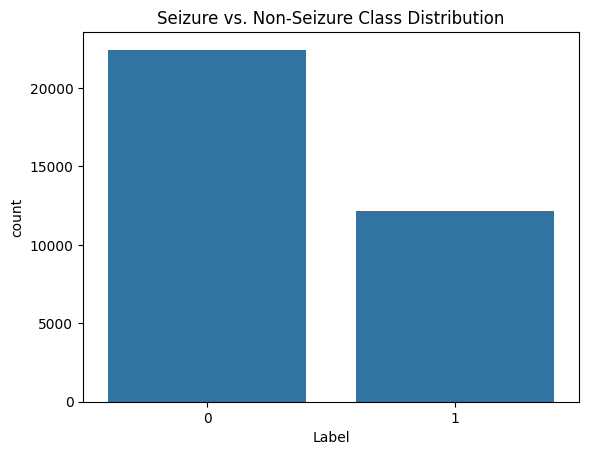

Label
0    0.649151
1    0.350849
Name: proportion, dtype: float64
Imbalance Ratio: 1.85


In [ ]:
sns.countplot(x=selected_scaled_features_df["Label"])
plt.title("Seizure vs. Non-Seizure Class Distribution")
plt.show()
print(selected_scaled_features_df["Label"].value_counts(normalize=True))
class_counts = selected_scaled_features_df["Label"].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

# SVM Training and Testing

In [ ]:
X = selected_scaled_features_df.drop(columns=["Label", "Segment_Start", "Segment_End"])
y = selected_scaled_features_df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the model

svm_model = SVC(kernel="rbf", class_weight="balanced", C=1, gamma="scale", random_state=42)
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', random_state=42)

Model Accuracy: 0.9625
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4487
           1       0.98      0.91      0.94      2425

    accuracy                           0.96      6912
   macro avg       0.97      0.95      0.96      6912
weighted avg       0.96      0.96      0.96      6912



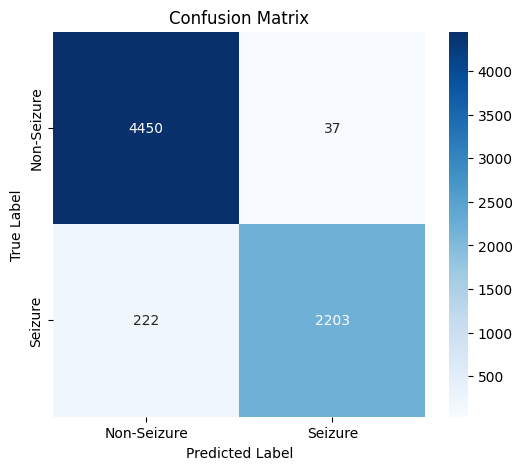

In [ ]:
# Predict on test set
y_pred = svm_model.predict(X_test)

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Seizure", "Seizure"], yticklabels=["Non-Seizure", "Seizure"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# # Use SVM as the base model for RFE
# svm = SVC(kernel="linear", class_weight="balanced")

# # Perform Recursive Feature Elimination (RFE)
# rfe = RFE(svm, n_features_to_select=10)  # Adjust number of top features
# rfe.fit(X_train, y_train)

# # Get feature rankings
# feature_ranks = pd.DataFrame({
#     "Feature": X.columns,
#     "Rank": rfe.ranking_
# }).sort_values(by="Rank", ascending=True)

In [ ]:
# feature_ranks

NameError: name 'feature_ranks' is not defined

- Try using umap analysis and PCA.
    - UMAP conserves more non-linear features
    - PCA is for linear features
- Look at the false negative and false positive segments. Plot out hte signals.
- Feature extractions:
    -   limit the features in the time domain to Mean, Variance, Energy.
- Take care of outliers in the data so our normalization doesn't get skewed.

In [ ]:
all_files = ["./241217_seizure_KCNA_long1.dat", "./241207_seizure_KCNA_long1.dat"]
annotation_names = ["KCNA_1207", "KCNA_1217"]
zipped_datafiles = list(zip(all_files, annotation_names))
for dataset in zipped_datafiles:
    print(dataset[0], dataset[1])
	

./241217_seizure_KCNA_long1.dat KCNA_1207
./241207_seizure_KCNA_long1.dat KCNA_1217


In [32]:
li = []
all_files = ["./241217_seizure_KCNA_long1.dat", "./241207_seizure_KCNA_long1.dat"]
annotation_names = ["KCNA_1217", "KCNA_1207"]
zipped_datafiles = list(zip(all_files, annotation_names))
train_list = []
test_list = []

for dataset in zipped_datafiles:
    # Read and preprocess the EEG data
    original_eeg_df = pd.read_csv(dataset[0])
    eeg_df = original_eeg_df[["EEG", "Max_Time"]]
    eeg_signal = eeg_df['EEG'].to_numpy()
    time_stamps = eeg_df['Max_Time'].to_numpy()
    filtered_signal = highpass_filter(eeg_signal, 5, SAMPLING_FS)
    
    SEGMENTATION_LENGTH = 2560
    NUM_SAMPLES = len(filtered_signal)
    TRIMMED_LENGTH = NUM_SAMPLES % SEGMENTATION_LENGTH
    trimmed_signal = filtered_signal[TRIMMED_LENGTH:]
    trimmed_time_stamps = time_stamps[TRIMMED_LENGTH:]
    
    OVERLAP = 0.5  # 50% overlap
    STEP_SIZE = int(SEGMENTATION_LENGTH * (1 - OVERLAP))
    total_samples = len(trimmed_signal)
    
    # Create overlapping segments
    segmented_signal = np.array([
        trimmed_signal[i : i + SEGMENTATION_LENGTH] 
        for i in range(0, total_samples - SEGMENTATION_LENGTH + 1, STEP_SIZE)
    ])
    segmented_time_stamps = np.array([
        trimmed_time_stamps[i : i + SEGMENTATION_LENGTH] 
        for i in range(0, total_samples - SEGMENTATION_LENGTH + 1, STEP_SIZE)
    ])
    
    # Load annotations and adjust them (multiplying by 60*1000)
    annotations = pd.read_excel("./zqm_annotation_seizure.xlsx", sheet_name=dataset[1])
    annotations = annotations[['Start', 'End']].apply(lambda x: 60 * 1000 * x)
    annotations = annotations.dropna()
    
    # Create features from the segmented signal and annotations
    features_df = create_dataset(segmented_signal, segmented_time_stamps, annotations)
    
    # Feature Normalization using Standardization
    features = features_df.drop(columns=["Label", "Segment_Start", "Segment_End"])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    scaled_features_df = pd.DataFrame(features_scaled, columns=features.columns)
    
    # Add the label and segmentation info back into the DataFrame
	
    scaled_features_df["Label"] = features_df["Label"]
    scaled_features_df["Segment_Start"] = features_df["Segment_Start"]
    scaled_features_df["Segment_End"] = features_df["Segment_End"]
    
    # Feature Selection: remove near-constant features
    selector = VarianceThreshold(threshold=0.1)
    selected_scaled_features = selector.fit_transform(scaled_features_df.drop(columns=["Label", "Segment_Start", "Segment_End"]))
    selected_features = features.columns[selector.get_support()]
    selected_scaled_features_df = pd.DataFrame(selected_scaled_features, columns=selected_features)
    selected_scaled_features_df["Label"] = features_df["Label"]
    selected_scaled_features_df["Segment_Start"] = features_df["Segment_Start"]
    selected_scaled_features_df["Segment_End"] = features_df["Segment_End"]
    
    # Prepare X (features) and y (labels)
    X = selected_scaled_features_df.drop(columns=["Label", "Segment_Start", "Segment_End"])
    y = selected_scaled_features_df["Label"]
    
    # Split the current dataset into 25% training and 75% testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.75, random_state=42, stratify=y
    )
    
    # Create DataFrames for the splits including the labels
    train_temp = X_train.copy()
    train_temp["Label"] = y_train
    test_temp = X_test.copy()
    test_temp["Label"] = y_test
    
    # Append the splits to their respective lists
    train_list.append(train_temp)
    test_list.append(test_temp)

# Combine all training splits and all testing splits into final datasets
final_train = pd.concat(train_list, ignore_index=True)
final_test = pd.concat(test_list, ignore_index=True)

Extracting Features:   0%|          | 0/34559 [00:00<?, ?segment/s]/var/folders/qq/k25z65411f76vz0kh3p7b2000000gn/T/ipykernel_10327/3507049422.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx_band], f[idx_band])
Extracting Features:   0%|          | 0/34859 [00:00<?, ?segment/s]/var/folders/qq/k25z65411f76vz0kh3p7b2000000gn/T/ipykernel_10327/3507049422.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx_band], f[idx_band])
Extracting Features: 100%|██████████| 34859/34859 [03:37<00:00, 160.38segment/s]


In [37]:
# X = features_dataset.drop(columns=["Label", "Segment_Start", "Segment_End"])
# y = features_dataset["Label"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the model
# Prepare the training data: separate features and labels
X_train = final_train.drop(columns=["Label"])
y_train = final_train["Label"]

# Prepare the testing data: separate features and labels
X_test = final_test.drop(columns=["Label"])
y_test = final_test["Label"]

svm_model = SVC(kernel="rbf", class_weight="balanced", C=1, gamma="scale", random_state=42)
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', random_state=42)

In [39]:
X_test

,Mean,Variance,Energy,Wavelet_Mean_L0,Wavelet_Variance_L0,Wavelet_Skewness_L0,Wavelet_Kurtosis_L0,Wavelet_Energy_L0,Wavelet_Entropy_L0,Wavelet_Mean_L1,...,Wavelet_Skewness_L3,Wavelet_Kurtosis_L3,Wavelet_Energy_L3,Wavelet_Entropy_L3,Wavelet_Mean_L4,Wavelet_Variance_L4,Wavelet_Skewness_L4,Wavelet_Kurtosis_L4,Wavelet_Energy_L4,Wavelet_Entropy_L4
0,0.572348,-0.537072,-0.537075,-0.381379,-0.393335,0.313784,-0.459514,-0.393323,0.532845,0.747427,...,-0.526644,0.166898,-0.518559,0.121796,-0.158857,-0.478799,0.268514,-0.163790,-0.478798,0.484891
1,-0.078466,-0.556294,-0.556300,-0.897365,-0.370261,0.214869,-0.441506,-0.369335,0.240271,-0.309462,...,-0.008301,-0.330555,-0.570671,0.653664,1.290855,-0.412320,0.000127,-0.344229,-0.412319,0.529401
2,-0.620272,-0.656753,-0.656753,-0.738744,-0.569864,-0.065610,-0.434044,-0.568682,-0.027436,0.052601,...,-0.196012,-0.328491,-0.581294,0.736104,0.582175,-0.555932,-0.020762,-0.368250,-0.555932,0.643963
3,-0.419129,-0.091924,-0.091933,-0.455932,0.239080,-0.757575,0.543310,0.237147,-1.285132,-0.404630,...,-0.280469,-0.331074,-0.566199,0.768676,0.274462,-0.506205,-0.021760,-0.394500,-0.506205,0.824074
4,0.097326,-0.720043,-0.720047,0.860715,-0.629714,0.800497,-0.333790,-0.628087,-0.047659,-0.243475,...,-0.185474,-0.305756,-0.619862,0.708939,0.347917,-0.624863,-0.118611,-0.394079,-0.624862,0.742963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52060,-0.171675,-0.079549,-0.079559,-0.110139,-0.010575,-2.065147,2.076382,-0.011059,-1.305228,0.366696,...,-0.070844,-0.398606,-0.403616,0.585758,-0.110380,-0.418970,0.036023,-0.345233,-0.418955,0.523912
52061,0.157002,-0.283204,-0.283210,-0.212051,-0.261194,-0.212520,-0.166115,-0.261030,0.140235,0.600798,...,2.758046,2.129634,-0.295159,-0.292964,-0.116768,-0.438099,0.302815,-0.218866,-0.438082,0.275494
52062,1.614517,0.015097,0.015114,0.089579,0.112631,0.404803,1.948739,0.111833,-1.541112,0.040192,...,-0.005132,-0.377135,-0.381901,0.596823,0.085574,-0.395581,-0.005007,-0.338595,-0.395566,0.510581
52063,-0.164769,-0.375776,-0.375781,0.040310,-0.331389,0.121794,-0.479915,-0.331071,0.638772,0.138440,...,-0.060014,-0.402622,-0.395035,0.568062,0.042642,-0.397775,0.050092,-0.370421,-0.397760,0.718140


Model Accuracy: 0.9378
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     37488
           1       0.93      0.84      0.88     14577

    accuracy                           0.94     52065
   macro avg       0.94      0.91      0.92     52065
weighted avg       0.94      0.94      0.94     52065



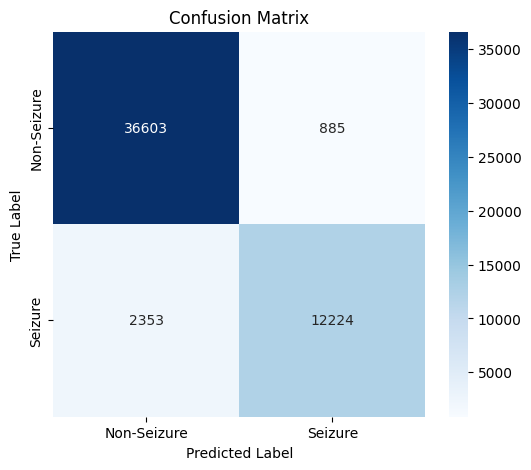

In [40]:
# Predict on test set
y_pred = svm_model.predict(X_test)

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Seizure", "Seizure"], yticklabels=["Non-Seizure", "Seizure"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
